In [1]:
import os
import numpy as np
import pandas as pd

from scipy.io import wavfile
import scipy.fftpack as fftpack
import scipy.signal.windows as windows

import pickle

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
DATASET_PATH = '.\data_v_7_stc'
FS = 16000
LOAD_DATA = True

In [4]:
TRAIN_DIR = os.path.join(DATASET_PATH, 'audio')
train_file = [f for f in os.listdir(TRAIN_DIR) if os.path.isfile(os.path.join(TRAIN_DIR, f))]
train_wave = [w for w in train_file if w[-4:] == '.wav']

In [5]:
df = pd.read_csv(os.path.join(DATASET_PATH, 'meta/meta.txt'), sep='\t', names=['File', '_', '__', 'Duration', 'Class'])
df.drop(['_', '__'], axis=1, inplace=True)

In [6]:
TEST_DIR = os.path.join(DATASET_PATH, 'test')
test_file = [f for f in os.listdir(TEST_DIR) if os.path.isfile(os.path.join(TEST_DIR, f))]
test_wave = [w for w in test_file if w[-4:] == '.wav']

test_tag_split = [(f.split('_'))[:-1] for f in test_wave]
test_tag_list = [ [tag for tag in tag_split if tag != 't'] for tag_split in test_tag_split]
test_tag = ['_'.join(tag_list) for tag_list in test_tag_list]

In [7]:
df_test = pd.DataFrame(np.concatenate((test_wave, test_tag)).reshape(-1, 2, order='F'), columns=['File', 'Class'])

In [8]:
tags = np.unique(test_tag)
d_class = dict(zip(tags, range(tags.shape[0])))
d_class_inv = {val:key for key, val in d_class.items()}

In [9]:
def preproc_wavfile(full_file_name):
    fs, data = wavfile.read(full_file_name)
    data_scaled = signal_scaler(data)
    signal_part = signal_detector(data_scaled, fs//10, fs//10, 10)
    
    return data_scaled, fs, signal_part

def signal_scaler(data, maximum=2**15 - 1):
    scale = maximum / max(abs(data))
    
    return np.array(data*scale, dtype=data.dtype)

def std_average(data, window):
    N = data.shape[0]
    W = int(window)
    HW = int(window // 2)
    if (N <= W):
        return np.array([data.mean()], dtype=data.dtype)
    
    data_std  = np.zeros(int((2*(N//W + 1)),), dtype=data.dtype)
    
    data_std[0] = data[:HW].std()
    for i in range(data_std.shape[0] - 2):
        data_std[i+1] = data[i*HW:(i+2)*HW].std()
    data_std[-1] = data[-HW:].std()

    return data_std

def signal_detector(data, window, min_duration_frame, scale=10):
    data_std = std_average(data, window)
    
    std_filter = np.zeros(data_std.shape, dtype='bool')
    std_filter[data_std > max(data_std)/scale] = True
       
    while (all(std_filter)):
        scale /= 2
        std_filter = np.zeros(data_std.shape, dtype='bool')
        std_filter[data_std > max(data_std)/scale] = True
        
    if (not any(std_filter)):
        return []
    
    HW = window//2
    signal_frame = []
    front = np.argwhere(std_filter).reshape(-1,)[0]
    back = 0
    is_signal = std_filter[0]
    signal_duration = 0
    silence_duration = 0
    for i, flag in enumerate(std_filter):
        if (flag and not is_signal):
            silence_duration = (i - back + 1)*HW
            is_signal = True
            if (silence_duration > min_duration_frame):
                if (signal_duration >= min_duration_frame):
                    signal_frame.append((max(0,             (front-1)*HW),
                                         min(data.shape[0], (back   )*HW)))
                front = i     
        if (not flag and is_signal):
            back = i
            is_signal = False
            signal_duration = (back - front + 1)*HW
            
    if (std_filter[-1]):
        signal_frame.append((max(0,(front-1)*HW), data.shape[0]))
    else:
        signal_frame.append((max(0,             (front-1)*HW),
                             min(data.shape[0], (back   )*HW)))     
    
    return signal_frame

In [10]:
def process_oscilogram_feature(DIR, file_name_list):
    signal_parts = [None] * len(file_name_list)
    feat_ndarray = np.zeros((len(file_name_list), 4))
    for i, file_name in enumerate(file_name_list):
        data_scaled, _, signal_part = preproc_wavfile(os.path.join(DIR, file_name))
        feat_ndarray[i] = oscilogram_feature(data_scaled, signal_part)
        signal_parts[i] = signal_part
        
    return feat_ndarray, ['std_median', 'power_median', 'ratio', 'part_count'], signal_parts

def oscilogram_feature(data_scaled, signal_part):
    if (len(signal_part) == 0):
        return np.std(data_scaled), np.median(data_scaled**2), 1, 0
    
    N = data_scaled.shape[0]
    signal_data = np.ndarray((0,))
    signal_duration = 0
    for front, back in signal_part:
        signal_data = np.concatenate((signal_data, data_scaled[front:back]))
        signal_duration += back - front
    std_median = np.std(signal_data)
    power_median = np.median(signal_data**2)
    ratio = signal_duration / N
    part_count = len(signal_part)
    
    return std_median, power_median, ratio, part_count

In [11]:
if (not LOAD_DATA):
    train_oscilo_feat, columns, train_signal_parts = process_oscilogram_feature(TRAIN_DIR, df['File'])
    np.save('./feat_oscilo_train.npy', train_oscilo_feat)
    with open('./signal_parts_train.bin', 'wb') as fout: pickle.dump(train_signal_parts, fout)
else:
    train_oscilo_feat = np.load('./feat_oscilo_train.npy')
    with open('./signal_parts_train.bin', 'rb') as fin: train_signal_parts = pickle.load(fin)
#df = pd.concat([df, pd.DataFrame(train_oscilo_feat, columns=columns)], axis=1)

In [12]:
if (not LOAD_DATA):
    test_oscilo_feat, columns, test_signal_parts = process_oscilogram_feature(TEST_DIR, df_test['File'])
    np.save('./feat_oscilo_test.npy', test_oscilo_feat)
    with open('./signal_parts_test.bin', 'wb') as fout: pickle.dump(test_signal_parts, fout)
else:
    test_oscilo_feat = np.load('./feat_oscilo_test.npy')
    with open('./signal_parts_test.bin', 'rb') as fin: test_signal_parts = pickle.load(fin)
#df_test = pd.concat([df_test, pd.DataFrame(test_oscilo_feat, columns=columns)], axis=1)

In [13]:
def moving_average(data, window):
    s = pd.Series(data).rolling(window=window).mean()
    s = s.shift(-window//2).dropna().tolist()
    
    return s[:1]*(window//2) + s + s[-1:]*(window//2 - 1)

def exponential_smoothing(data, alpha):
    result = [data[0]] # first value is same as series
    for n in range(1, len(data)):
        result.append(alpha * data[n] + (1 - alpha) * result[n-1])
        
    return result

def fft(data, fs, func_avr=None, *param):
    data = np.array(data)
    if (data.shape[0] % fs != 0):
        data = np.concatenate((data, np.zeros((fs - data.shape[0] % fs, ) , dtype=data.dtype)), axis=0)
    
    N = data.shape[0]
    fn = fs//2  
    n = N//2
    
    X = fftpack.fft(data) / (N / 2.0)
    mag = np.abs(X / abs(X).max())[:n]
    X_db = 20*np.log10(mag)
    freq = fftpack.fftfreq(N, 1/fs)[:n]

    spec = X_db.reshape(fn, -1).mean(axis=1)
    if (func_avr is not None):
        spec = np.array(func_avr(spec, *param))
    
    return (spec, list(range(1, fn + 1)))

In [14]:
def process_spectral_feature(DIR, file_name_list, sample_rate=FS):
    signal_parts = [None] * len(file_name_list)
    feat_ndarray = np.zeros((len(file_name_list), sample_rate//2))
    for i, file_name in enumerate(file_name_list):
        data_scaled, fs, signal_part = preproc_wavfile(os.path.join(DIR, file_name))
        feat, freq = spectrum_feature(data_scaled, fs, signal_part)
        feat_ndarray[i], frequency_range = feat[:sample_rate//2], freq[:sample_rate//2]
        signal_parts[i] = signal_part
        
    return feat_ndarray, frequency_range, signal_parts

def spectrum_feature(data, fs, signal_part):
    if (len(signal_part) == 0):
        window = windows.hann(data.shape[0])
        return fft(window*data, fs, moving_average, fs//100)

    N = data.shape[0]
    signal_data = np.ndarray((0,))
    for front, back in signal_part:
        window = windows.hann(back - front)
        signal_data = np.concatenate((signal_data, window*data[front:back]))

    return fft(signal_data, fs, moving_average, fs//100)

In [15]:
if (not LOAD_DATA):
    train_spectr_feat, columns, _ = process_spectral_feature(TRAIN_DIR, df['File'])
    np.save('./feat_spectr_train.npy', train_spectr_feat)
else:
    train_spectr_feat = np.load('./feat_spectr_train.npy')
#df = pd.concat([df, pd.DataFrame(train_spectr_feat, columns=columns)], axis=1)

In [16]:
if (not LOAD_DATA):
    test_spectr_feat, columns, _ = process_spectral_feature(TEST_DIR, df_test['File'])
    np.save('./feat_spectr_test.npy', test_spectr_feat)
else:
    test_spectr_feat = np.load('./feat_spectr_test.npy')
#df_test = pd.concat([df_test, pd.DataFrame(test_spectr_feat, columns=columns)], axis=1)

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.multiclass import OneVsRestClassifier

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

def get_data(mode_list):
    X = np.ndarray((df.shape[0], 0))
        
    for mode in mode_list:
        if (mode == 'oscilo'):
            X = np.concatenate((X, train_oscilo_feat), axis=1)
        elif (mode == 'spec'):
            X = np.concatenate((X, train_spectr_feat), axis=1)
        
    y = df['Class'].map(d_class)
    
    return X, y

def cross_val(pipe, mode_list=['oscilo']):
    '''
    mode_list = ['oscilo', 'spec']
    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    X, y = get_data(mode_list)

    scores = cross_val_score(pipe, X, y, cv=skf, scoring='accuracy', n_jobs=-1, verbose=False)
    print(mode_list)
    print('Mean score = %.3f, score std = %.5f' % (np.mean(scores), np.std(scores)))
    
    return scores

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import GridSearchCV

def plot_grid_scores_1D(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'], color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'], color='red', label='test')
    plt.legend();
    
def plot_grid_scores_2D(grid, param_grid):
    col_num = 1
    xlabel = ''
    param_name_list = list(param_grid.keys())
    for param_name in param_name_list:
        col_num = np.diff(np.argwhere(np.diff(grid_pipe.cv_results_['param_'+param_name].data)).reshape(1,-1))[0][0]
        if (col_num != 1):
            xlabel = param_name
            break
    if (col_num == 1):
        return
    
    param_name_list.remove(xlabel)
    ylabel = param_name_list[0]
    grid = (grid_pipe.cv_results_['mean_test_score']).reshape(-1, col_num)
    sns.heatmap(pd.DataFrame(grid, index=list(param_grid[xlabel]), columns=list(param_grid[ylabel])),
                vmin=np.min(grid), vmax=np.max(grid), annot=True, fmt='.4g')
    plt.xlabel(ylabel)
    plt.ylabel(xlabel);
    
def grid_serach(pipe, param_grid, mode_list=['oscilo']):
    '''
    mode = ['oscilo', 'spec']
    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

    X, y = get_data(mode_list)

    grid_pipe = GridSearchCV(pipe, param_grid, cv=skf, n_jobs=-1, return_train_score=True)

    grid_pipe.fit(X, y)
    
    print(mode_list)
    print(grid_pipe.best_params_, grid_pipe.best_score_)
    
    if (len(param_grid) == 1):
        plot_grid_scores_1D(grid_pipe, list(param_grid.keys())[0])
    elif (len(param_grid) == 2):
        plot_grid_scores_2D(grid_pipe, param_grid)
    
    return grid_pipe.best_params_, grid_pipe.best_score_

['oscilo']
{'logit__C': 4.0} 0.613159989387


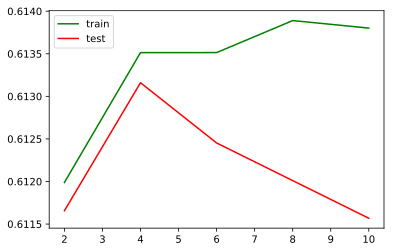

In [59]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])

best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(2, 10, 5)})

In [60]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=4, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe)

['oscilo']
Mean score = 0.613, score std = 0.00820


array([ 0.60326567,  0.60415745,  0.62229102,  0.62168142,  0.61443116])

['oscilo']
{'logit__C': 10.0, 'poly__degree': 5} 0.705138409835


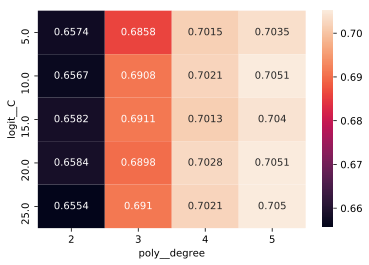

In [114]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)),
                    ('scaler', StandardScaler()),
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])

best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(5, 25, 5),
                                      'poly__degree': np.linspace(2, 5, 4, dtype='int')})

In [115]:
lg_pipe = Pipeline([('poly', PolynomialFeatures(degree=5)),
                    ('scaler', StandardScaler()),
                    ('logit', LogisticRegression(C=10, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe)

['oscilo']
Mean score = 0.705, score std = 0.00333


array([ 0.70344219,  0.7023441 ,  0.71163202,  0.70353982,  0.70473661])

['spec']
{'logit__C': 10.0} 0.819757672238


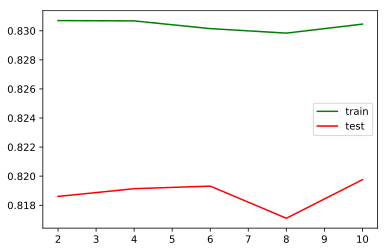

In [120]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])

best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(2, 10, 5)}, ['spec'])

In [121]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['spec'])

['spec']
Mean score = 0.820, score std = 0.00654


array([ 0.82082966,  0.82662539,  0.82220257,  0.80752212,  0.8229305 ])

['oscilo', 'spec']
{'logit__C': 10.0} 0.879366763952


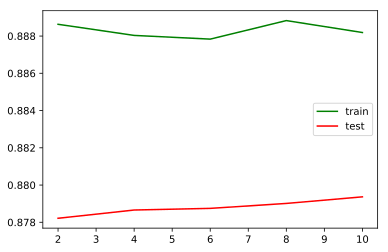

In [118]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=1, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])

best_param, _ = grid_serach(lg_pipe, {'logit__C': np.linspace(2, 10, 5)}, ['oscilo', 'spec'])

In [119]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])
cross_val(lg_pipe, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.879, score std = 0.00767


array([ 0.8874669 ,  0.88323751,  0.87881468,  0.86504425,  0.88224878])

In [20]:
lg_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=.9)),
                    ('logit', LogisticRegression(C=5, penalty='l2', solver='lbfgs',
                                                 multi_class='multinomial', n_jobs=-1, random_state=17))])

cross_val(lg_pipe, ['oscilo', 'spec'])
#best_param, _ = grid_serach(lg_pipe, {'pca__n_components': np.linspace(0.85, 0.95, 3)}, ['oscilo', 'spec'])

['oscilo', 'spec']
Mean score = 0.539, score std = 0.00586


array([ 0.54457193,  0.536046  ,  0.53427687,  0.53185841,  0.54670208])

In [27]:
X = df_spec.iloc[:,-(FS//2 + 4):].values
y = df_spec['Class'].map(d_class).values

test_close_index = (df_test_spec['Class'] != 'unknown')

X_test_open = df_test_spec.iloc[:,-(FS//2 + 4):].values
y_test_open = df_test_spec['Class'].map(d_class).values
y_test_close = y_test_open[test_close_index]

data_scaler = StandardScaler()
X_scaled = data_scaler.fit_transform(X)
X_test_open_scaled = data_scaler.transform(X_test_open)

In [29]:
rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1))
rfc.fit(X, y)
rfc_cls_open = rfc.predict(X_test_open)
rfc_proba_open = rfc.predict_proba(X_test_open)

rfc_cls_close = rfc_cls_open[test_close_index]
rfc_proba_close = rfc_proba_open[test_close_index]

print(accuracy_score(y_test_close, rfc_cls_close))
rfc_cfm = confusion_matrix(rfc_cls_close, y_test_close)
pd.DataFrame(np.vstack((rfc_cfm, rfc_cfm.sum(axis=0),
                        [round(rfc_cfm[i, i] / rfc_cfm.sum(axis=0)[i], ndigits=2) for i in range(rfc_cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.799154334038


,back,bags,door,keyb,knoc,ring,spee,tool
background,25.00,0.0,3.00,1.00,3.00,0.00,7.00,0.0
bags,0.00,40.0,6.00,4.00,0.00,0.00,0.00,0.0
door,0.00,7.0,34.00,3.00,6.00,0.00,4.00,0.0
keyboard,1.00,1.0,2.00,24.00,0.00,0.00,0.00,0.0
knocking_door,1.00,0.0,0.00,0.00,49.00,0.00,3.00,0.0
ring,0.00,0.0,0.00,0.00,0.00,71.00,0.00,0.0
speech,0.00,0.0,0.00,0.00,0.00,0.00,121.00,0.0
tool,14.00,2.0,4.00,15.00,1.00,1.00,6.00,14.0
Total,41.00,50.0,49.00,47.00,59.00,72.00,141.00,14.0
Recall,0.61,0.8,0.69,0.51,0.83,0.99,0.86,1.0


In [30]:
svc = SVC(C=10, kernel='rbf', gamma='auto', decision_function_shape='ovr', random_state=17, probability=True)
svc.fit(X_scaled, y)
svc_cls_open = svc.predict(X_test_open_scaled)
svc_proba_open = svc.predict_proba(X_test_open_scaled)

svc_cls_close = svc_cls_open[test_close_index]
svc_proba_close = svc_proba_open[test_close_index]

print(accuracy_score(y_test_close, svc_cls_close))
svc_cfm = confusion_matrix(svc_cls_close, y_test_close)
pd.DataFrame(np.vstack((svc_cfm, svc_cfm.sum(axis=0),
                        [round(svc_cfm[i, i] / svc_cfm.sum(axis=0)[i], ndigits=2) for i in range(svc_cfm.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.832980972516


,back,bags,door,keyb,knoc,ring,spee,tool
background,39.00,0.00,4.00,0.00,4.00,4.00,5.00,0.00
bags,0.00,49.00,4.00,4.00,0.00,0.00,0.00,0.00
door,0.00,0.00,33.00,3.00,7.00,1.00,6.00,2.00
keyboard,1.00,1.00,1.00,29.00,0.00,0.00,0.00,0.00
knocking_door,0.00,0.00,0.00,0.00,43.00,0.00,2.00,1.00
ring,0.00,0.00,0.00,0.00,0.00,67.00,1.00,0.00
speech,0.00,0.00,2.00,0.00,4.00,0.00,123.00,0.00
tool,1.00,0.00,5.00,11.00,1.00,0.00,4.00,11.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.95,0.98,0.67,0.62,0.73,0.93,0.87,0.79


In [31]:
'''
Хотел еще добавить бустинг (так как он тоже себя хорошо показал (0.7928 см. research)).
Но времени на его обучение для solution уже не хватило
Принятие решения должно было бы иметь вид:
beta*(alpha*svc_proba + (1.0 - alpha)*rfc_proba) + (1.0 - beta)*gbc_proba
'''
alpha = 0.4
proba_open = alpha*svc_proba_open + (1.0 - alpha)*rfc_proba_open
cls_open = np.array([np.argmax(proba) for proba in proba_open])

proba_close = proba_open[test_close_index]
cls_close = cls_open[test_close_index]
print(accuracy_score(y_test_close, cls_close))
cfm_close = confusion_matrix(cls_close, y_test_close)
pd.DataFrame(np.vstack((cfm_close, cfm_close.sum(axis=0),
                        [round(cfm_close[i, i] / cfm_close.sum(axis=0)[i], ndigits=2) for i in range(cfm_close.shape[0])])),
             index=list(d_class.keys())[:-1] + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())[:-1]])

0.858350951374


,back,bags,door,keyb,knoc,ring,spee,tool
background,32.00,0.00,2.00,0.00,2.00,2.00,2.00,0.00
bags,0.00,48.00,5.00,4.00,0.00,0.00,0.00,0.00
door,0.00,0.00,37.00,2.00,7.00,0.00,4.00,1.00
keyboard,1.00,1.00,1.00,30.00,0.00,0.00,0.00,0.00
knocking_door,0.00,0.00,0.00,0.00,48.00,0.00,2.00,0.00
ring,0.00,0.00,0.00,0.00,0.00,70.00,0.00,0.00
speech,1.00,0.00,1.00,0.00,1.00,0.00,128.00,0.00
tool,7.00,1.00,3.00,11.00,1.00,0.00,5.00,13.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00
Recall,0.78,0.96,0.76,0.64,0.81,0.97,0.91,0.93


In [32]:
df_result_close = pd.concat([(df_test_spec[test_close_index])['File'],
                             pd.Series([np.max(proba) for proba in proba_close], name='Score'),
                             pd.Series([d_class_inv[cls] for cls in cls_close], name='Class')], axis=1)
df_result_close.to_csv('./result_close.txt', sep='\t', header=False, index=False, float_format='%.3f')

In [33]:
'''
Для открытой задачи классификации выберем порог
соответствующий медиане оценки класса (score) для неправильно распознанных данных
'''
open_threshold = np.median(np.array([proba_close[i, cls] for i, cls in enumerate(cls_close)])[y_test_close != cls_close])
print('threshold = %.4f' % open_threshold)

threshold = 0.5658


In [34]:
cls_open[[np.max(proba) for proba in proba_open] < open_threshold] = d_class['unknown']

print(accuracy_score(y_test_open, cls_open))
cfm_open = confusion_matrix(cls_open, y_test_open)
pd.DataFrame(np.vstack((cfm_open, cfm_open.sum(axis=0),
                        [round(cfm_open[i, i] / cfm_open.sum(axis=0)[i], ndigits=2) for i in range(cfm_open.shape[0])])),
             index=list(d_class.keys()) + ['Total', 'Recall'],
             columns=[str[:4] for str in list(d_class.keys())])

0.731147540984


,back,bags,door,keyb,knoc,ring,spee,tool,unkn
background,25.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,5.00
bags,0.00,39.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00
door,0.00,0.00,24.00,1.00,2.00,0.00,3.00,0.00,8.00
keyboard,1.00,1.00,0.00,26.00,0.00,0.00,0.00,0.00,0.00
knocking_door,0.00,0.00,0.00,0.00,46.00,0.00,2.00,0.00,4.00
ring,0.00,0.00,0.00,0.00,0.00,66.00,0.00,0.00,6.00
speech,0.00,0.00,1.00,0.00,0.00,0.00,107.00,0.00,4.00
tool,4.00,0.00,2.00,8.00,0.00,0.00,2.00,12.00,9.00
unknown,11.00,10.00,19.00,10.00,10.00,5.00,27.00,2.00,101.00
Total,41.00,50.00,49.00,47.00,59.00,72.00,141.00,14.00,137.00


In [35]:
df_result_open = pd.concat([df_test_spec['File'],
                            pd.Series([np.max(proba) for proba in proba_open], name='Score'),
                            pd.Series([d_class_inv[cls] for cls in cls_open], name='Class')], axis=1)
df_result_open.to_csv('./result_open.txt', sep='\t', header=False, index=False, float_format='%.3f')